# Model Selection

Many times when we fit some model to our data we face the problem of choosing the optimal one out of a set of models. 
This scenario occurs either by different values of $\lambda$ in-front of a regularization term or by some innate 
"complexity knob" of the hypothesis class. These knobs are additional parameters, called hyper-parameters, that we should
fit a value for. By selecting what value we want we select the model our of the family of models.

In the following lab we will use Cross-Validation to fit a value of the hyper-parameter $k$ in the KNN classifier. 

The code below utilizes the South African Heart Disease dataset published by "The Elements of Statistical Learning" 
and is available here: https://web.stanford.edu/~hastie/ElemStatLearn//data.html

In [204]:
import pandas as pd

df = pd.read_csv("SAheart.data", header=0, index_col=0).sort_values('chd')
df.famhist = df.famhist == "Present"
df.head()



,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
row.names,,,,,,,,,,
170,162,5.30,7.95,33.58,True,58,36.06,8.23,48,0
226,143,5.04,4.86,23.59,False,58,24.69,18.72,42,0
225,132,7.28,3.52,12.33,False,60,19.48,2.06,56,0
223,144,2.40,8.13,35.61,False,46,27.38,13.37,60,0
385,128,2.60,4.94,21.36,False,61,21.30,0.00,31,0


In [205]:
import numpy as np
from sklearn.model_selection import train_test_split 

np.random.seed(1)

train, test = train_test_split(df, test_size=0.2)
trainX, trainY, testX, testY = train.loc[:, train.columns != 'chd'], train["chd"], test.loc[:, test.columns != 'chd'], test["chd"]

print("After splitting, we got %d train samples and %d test samples" % (len(train), len(test)))


After splitting, we got 392 train samples and 70 test samples


# Fitting a $k$-NN Classifier

In [206]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=20).fit(trainX, trainY)
print("Train accuracy: %.2f.\nTest accuracy: %.2f" % ( knn.score(trainX, trainY), knn.score(testX, testY) ))


Train accuracy: 0.71.
Test accuracy: 0.67


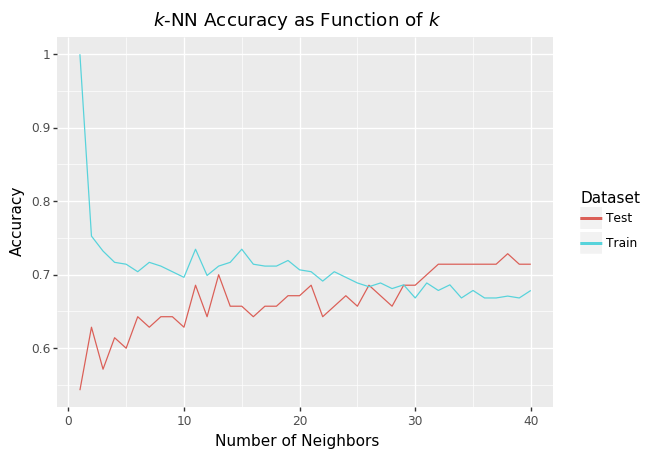

<ggplot: (-9223371866437424061)>

In [207]:
ks = range(1, 41)
train, test = [], []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k).fit(trainX, trainY)
    train.append(knn.score(trainX, trainY))
    test.append(knn.score(testX, testY))

from plotnine import *
p = (ggplot(pd.melt(pd.DataFrame({"k": ks, "Train": train, "Test": test}), id_vars="k"), 
       aes(x="k", y="value", color="variable")) + 
 geom_line() + 
 labs(x="Number of Neighbors", y="Accuracy", color="Dataset", title=r"$k$-NN Accuracy as Function of $k$"))
p


# Cross Validation For Selecting $k$

Cross-Validation is a technique for assessment of an algorithm's generalization. We split our training data into fold, 
train our model on $n-1$ folds and test it on the $n$'th fold. We repeat the process over different selections of testing
(validation) folds. 

In the context of hyper-parameter optimization (i.e model selection) we perform the above for different values of the
hyper-parameter. When doing so we still need to determine what values of the hyper-parameter to check (for the $k$-NN
example, which values of $k$ to check).

Here too there are many techniques and heuristics: Suppose we had not 1 hyper-parameter but 10. Now suppose each hyper-
parameter resides in one of two values. This still means we have $2^{10}$ models we are comparing. Many times, especially
when using Neural Networks, we have many many hyper-parameters and each with many different possible values.

For the purposes of this course we will only consider the case of brute-force scanning all options, known as Grid Search.   

In [208]:
from sklearn.model_selection import GridSearchCV

# Specifying values to scan. Dictionary keys correspond to arguments passed to model's constructor.
param_grid = {'n_neighbors':ks}

# Perform the Cross-Validation (with 5 folds) over all combinations of parameter values specified in dictionary
knn_cv = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5).fit(trainX, trainY)

# The returned object has many interesting attributes and can be extended to include different objective functions.
# For more details see documentation: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
knn_cv.cv_results_



{'mean_fit_time': array([0.00199513, 0.00219736, 0.00279393, 0.00179586, 0.00179324,
        0.00179644, 0.00179534, 0.00199304, 0.00218139, 0.00179415,
        0.0019949 , 0.00378881, 0.00379086, 0.0057765 , 0.00239267,
        0.00219417, 0.00199485, 0.00200162, 0.00199332, 0.00199423,
        0.00199218, 0.00159121, 0.00199485, 0.00179577, 0.00199327,
        0.00199351, 0.00119658, 0.00179486, 0.00179572, 0.00199547,
        0.00199409, 0.00199466, 0.00200076, 0.00139627, 0.00179667,
        0.001791  , 0.00139494, 0.00179129, 0.00199304, 0.00180173]),
 'std_fit_time': array([8.91697705e-04, 4.00968184e-04, 3.82595535e-04, 3.99638830e-04,
        3.98097308e-04, 4.00374508e-04, 3.99544225e-04, 2.15214734e-05,
        7.33201220e-04, 3.98310884e-04, 9.53674316e-08, 7.45360368e-04,
        1.16299063e-03, 1.32629309e-03, 7.98516175e-04, 3.98993531e-04,
        3.37174788e-07, 1.31909052e-05, 3.40062129e-06, 4.04216184e-06,
        3.38319240e-06, 4.84204761e-04, 2.78450037e-06, 3.811

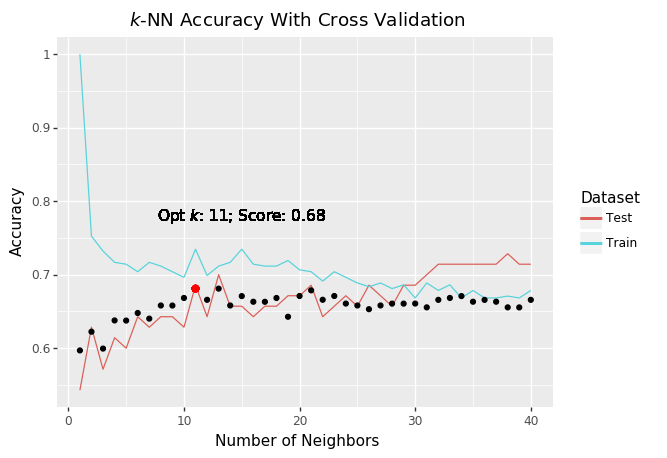

<ggplot: (-9223371866439035339)>

In [209]:
opt_k = knn_cv.best_params_["n_neighbors"]
opt_score = knn_cv.best_score_

(p + geom_point(data=pd.DataFrame({"k": ks ,"cv": knn_cv.cv_results_["mean_test_score"]}), 
               mapping=aes(x="k", y="cv"), color="black") + 
 geom_point(aes(x=opt_k, y=opt_score), color="Red", size=2) + 
 geom_text(label=r"Opt $k$: %d; Score: %.2f" % (opt_k, round(opt_score, 2)), x=opt_k + 4, y= opt_score + .1, color="black") +
 labs(title=r"$k$-NN Accuracy With Cross Validation"))


In [210]:
knn = KNeighborsClassifier(n_neighbors=opt_k).fit(trainX, trainY)
print("Train accuracy: %.2f.\nTest accuracy: %.2f" % ( knn.score(trainX, trainY), knn.score(testX, testY) ))


Train accuracy: 0.73.
Test accuracy: 0.69


# $\ell_1,\ell_2$ Regularization for Logistic Regression

In the following section we will fit a logistic regression model to the SA Hearts dataset, as we did in the logistic
regression lab. This time we will compare 3 types of fit: the ordinary, $\ell_1$ and $\ell_2$ logistic regressions.   

In [211]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(solver="saga", tol=1e-4, max_iter=1e4).fit(trainX, trainY)
print("Train accuracy: %.2f.\nTest accuracy: %.2f" % ( lg.score(trainX, trainY), lg.score(testX, testY) ))


Train accuracy: 0.72.
Test accuracy: 0.64


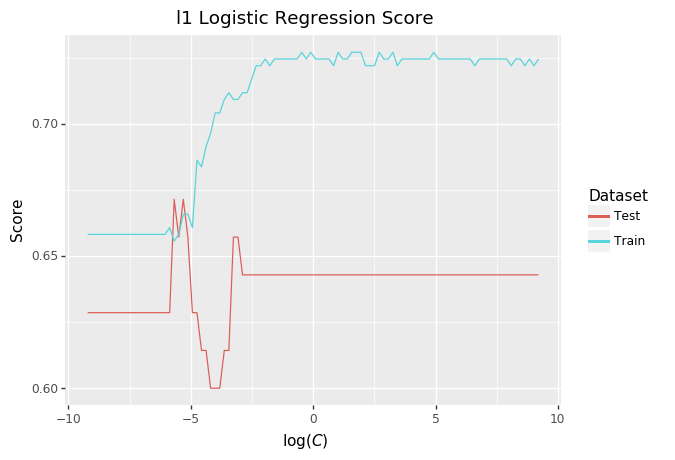

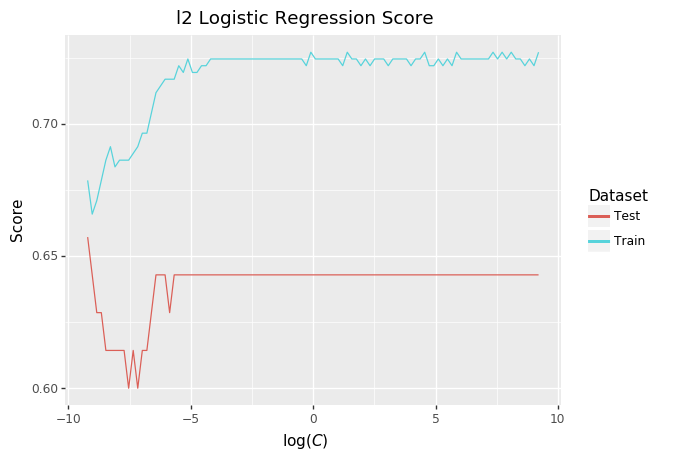

[<ggplot: (-9223371866436415309)>, <ggplot: (-9223371866437526226)>]

In [212]:
def plot_model_performance(penalty, Cs, trainX, trainY, testX, testY):
    """
    Given a penalty (regularization) type and a collection of C values to check, fit a penalized logistic regression 
    model for each over given training data. Then record scores over train and test in fitting arrays.
    :param penalty: Regularization type ("l1", "l2") 
    :param Cs: C values to check
    :param trainX: Design matrix to fit a model for
    :param trainY: Response vector to fit a model for
    :param testX: Design matrix to test model over
    :param testY: Response vector to test model over
    :return: A ggplot showing train and test scores of each fitted regularized model
    
    Hint: You already saw a graph like this earlier :)
    """
    train, test = [], []
    for c in Cs:
        # Fit a Logistic regression model and append train and test scores to lists. 
        # Set: `solver="sage"`, tol and max_iter as above. 
        # Do not forget to pass penalty type and C value.
        pass

    # Return a ggplot over score as a function of np.log(Cs). Include penalty type in plot's title
    return None


Cs = 2**np.linspace(-11,.5, 50)
l1_p = plot_model_performance("l1", Cs, trainX, trainY, testX, testY)
l2_p = plot_model_performance("l2", Cs, trainX, trainY, testX, testY)

[l1_p, l2_p]

In [213]:
from sklearn.linear_model import LogisticRegressionCV

# Complete the implementation of the following function
def fit_logistic_regression_cv(penalty, Cs, x, y, cv=5):
    """
    Fit a regularized logistic regression model while applying cross-validation 
    :param penalty: Regularization type ("l1", "l2")
    :param Cs: Collection of regularization weights to check
    :param x: Design matrix to fit a model for
    :param y: Response vector to fit a model for
    :param cv: Number of cross-validation folds to use
    :return: Fitted model
    """
    # Complete the following line and function implementation. Please check documentation of the LogisticRegressionCV class.
    pass

folds = 5
l1 = fit_logistic_regression_cv(penalty="l1", Cs=Cs, x=trainX, y=trainY, cv=folds)
l2 = fit_logistic_regression_cv(penalty="l2", Cs=Cs, x=trainX, y=trainY, cv=folds)


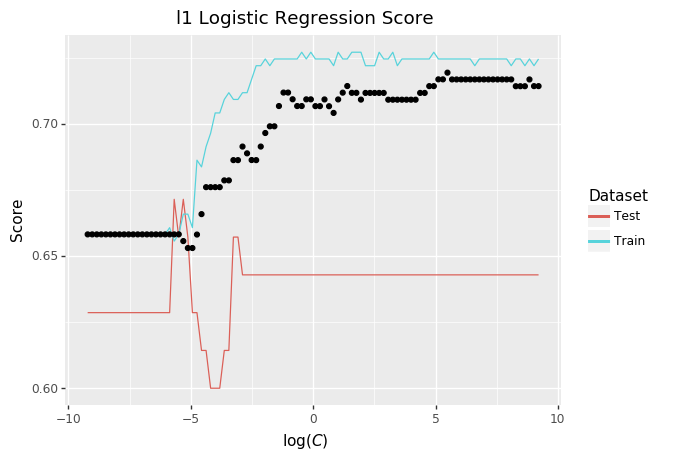

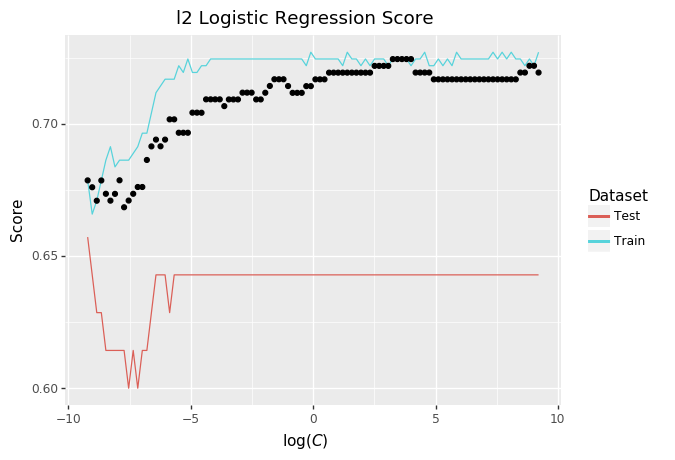

[<ggplot: (-9223371866438982568)>, <ggplot: (-9223371866436415323)>]

In [214]:
def append_cv_results(model, plot):
    """
    Given a trained CV model append to an existing plot the cross-validation results
    :param model: Fitted regularized with cross-validation logisitic regression model
    :param plot: Model's train and test scores as a function of the C value
    :return: The original plot with additional points (x,y) where x is the log of the matching C value and y the mean 
    score across all folds
    Hint: See similar graph above
    """
    # Do not use any variables defined outside of the function. Investigate the attributes of the LogisticRegressionCV
    # to find the values of Cs used and the cross validation scores
    pass

[append_cv_results(l1, l1_p), append_cv_results(l2, l2_p)]



In [215]:
c1, c2 = l1.C_[0], l2.C_[0]
l1 = LogisticRegression(solver="saga", tol=1e-4, max_iter=1e4, C=c1, penalty="l1").fit(trainX, trainY)
l2 = LogisticRegression(solver="saga", tol=1e-4, max_iter=1e4, C=c2, penalty="l2").fit(trainX, trainY)

pd.DataFrame({"Algorithm:": ["Logistic Regression", "l1 Logistic Regression", "l2 Logistic Regression"],
              "C Value": [None, c1, c2],
              "Train Error": [lg.score(trainX, trainY), l1.score(trainX, trainY), l2.score(trainX, trainY)],
              "Test Error": [lg.score(testX, testY), l1.score(testX, testY), l2.score(testX, testY)]}) 


,Algorithm:,C Value,Train Error,Test Error
0,Logistic Regression,NaN,0.72449,0.642857
1,l1 Logistic Regression,242.012826,0.72449,0.642857
2,l2 Logistic Regression,25.950242,0.72449,0.642857
